In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rocauc_comparison import delong_roc_test
from sklearn.metrics import (
    auc,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_curve,
)

## Load label and predictions

In [2]:
label = pd.read_pickle("../artifacts/label/label.pkl")

pred_baseline = pd.read_pickle("../artifacts/pred/pred_baseline.pkl")
pred_nsfw_classifier = pd.read_pickle("../artifacts/pred/pred_nsfw_classifier.pkl")

## ROC

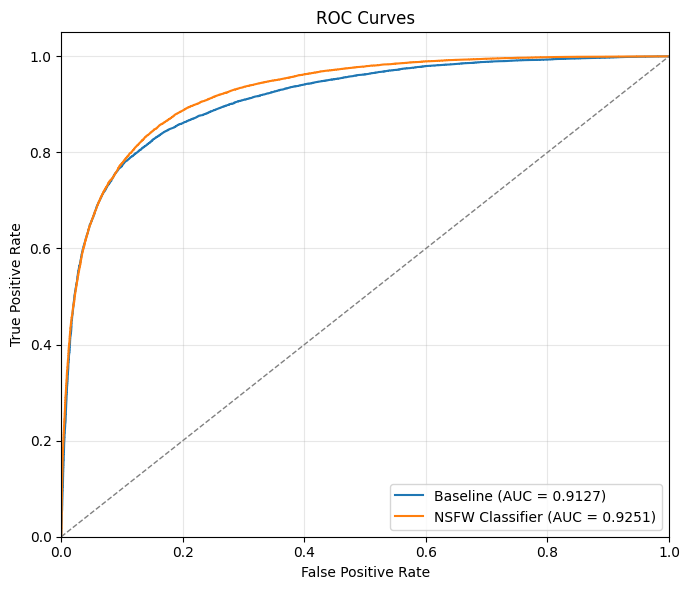

In [3]:
fpr_base, tpr_base, _ = roc_curve(label, pred_baseline)
auc_base = auc(fpr_base, tpr_base)

fpr_cls, tpr_cls, _ = roc_curve(label, pred_nsfw_classifier)
auc_cls = auc(fpr_cls, tpr_cls)

plt.figure(figsize=(7, 6))
plt.plot(fpr_base, tpr_base, label=f"Baseline (AUC = {auc_base:.4f})")
plt.plot(fpr_cls, tpr_cls, label=f"NSFW Classifier (AUC = {auc_cls:.4f})")

# Diagonal line = random classifier
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The **NSFW Classifier** achieves a higher AUC (0.9251) compared to the **baseline** (0.9127), indicating that it provides better overall discrimination between NSFW and non-NSFW prompts across all decision thresholds.

### DeLong's test for AUC

In [4]:
p_value = np.exp(
    delong_roc_test(
        label,
        pred_baseline,
        pred_nsfw_classifier,
    )
).item()
print(f"P-value (Baseline vs. NSFW Classifier): {p_value:.3e}")

P-value (Baseline vs. NSFW Classifier): 2.802e-11


The resulting p-value is extremely small (on the order of $10^{-11}$), indicating that the performance improvement of the **NSFW Classifier** over the **baseline** is **statistically significant** and very unlikely to be due to random variation.


## Metrics at each threshold

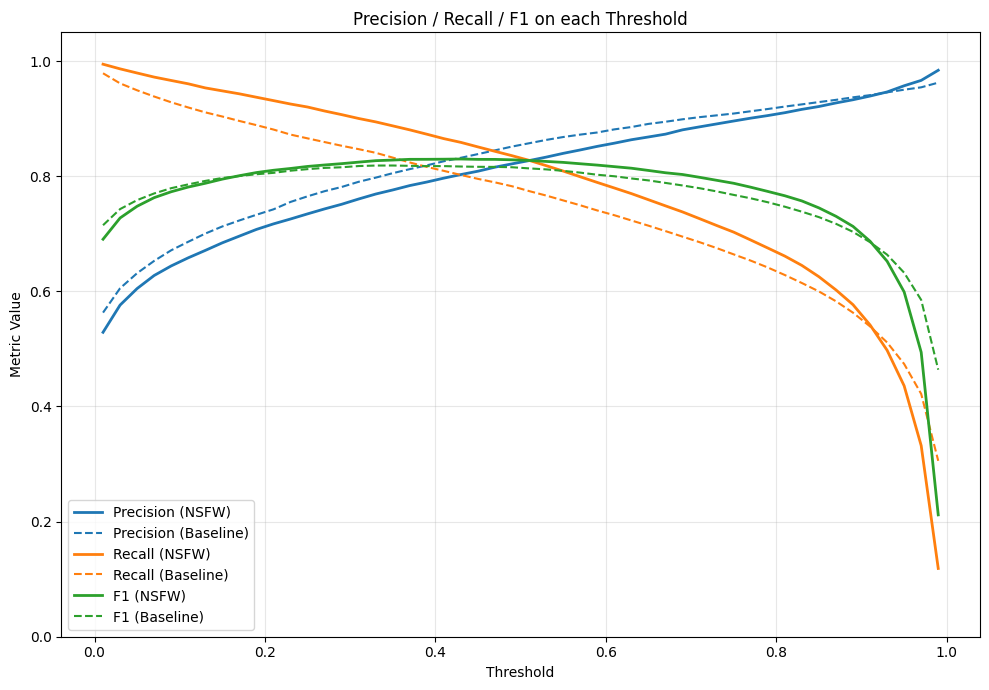

In [5]:
def metrics_at_threshold(y_true, y_prob, threshold: float):
    """Return precision, recall, F1, fpr, tpr for a given threshold."""
    y_pred = (y_prob >= threshold).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    tpr = tp / (tp + fn) if (tp + fn) else 0.0

    return precision, recall, f1, fpr, tpr


# Scan thresholds
thresholds = np.linspace(0.01, 0.99, 50)

# Metric storage
prec_base, rec_base, f1_base = [], [], []
prec_cls, rec_cls, f1_cls = [], [], []

for thr in thresholds:
    # Baseline
    p, r, f1, _, _ = metrics_at_threshold(label, pred_baseline, thr)
    prec_base.append(p)
    rec_base.append(r)
    f1_base.append(f1)

    # NSFW Classifier
    p, r, f1, _, _ = metrics_at_threshold(label, pred_nsfw_classifier, thr)
    prec_cls.append(p)
    rec_cls.append(r)
    f1_cls.append(f1)


plt.figure(figsize=(10, 7))

# Precision
plt.plot(thresholds, prec_cls, label="Precision (NSFW)", color="C0", linewidth=2)
plt.plot(
    thresholds, prec_base, label="Precision (Baseline)", color="C0", linestyle="--"
)

# Recall
plt.plot(thresholds, rec_cls, label="Recall (NSFW)", color="C1", linewidth=2)
plt.plot(thresholds, rec_base, label="Recall (Baseline)", color="C1", linestyle="--")

# F1
plt.plot(thresholds, f1_cls, label="F1 (NSFW)", color="C2", linewidth=2)
plt.plot(thresholds, f1_base, label="F1 (Baseline)", color="C2", linestyle="--")

plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Precision / Recall / F1 on each Threshold")
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

- **Recall (orange)**: The NSFW Classifier (solid line) achieves consistently higher recall than the baseline (dashed) across most thresholds. Only at the extreme high end of the threshold range (very close to 1.0), where both models’ recall collapses toward zero, does the baseline slightly overtake it. In the practically useful region, the NSFW model is more likely to catch NSFW samples.

- **Precision (blue)**: The precision curves of the two models are very close. At very low thresholds, the baseline has slightly higher precision; as the threshold increases, the gap narrows and the NSFW curve gradually catches up and slightly exceeds the baseline at higher thresholds. Overall, precision differences are modest compared to recall differences.

- **F1 score (green)**: Because the NSFW model has better recall and comparable precision over a wide range of thresholds, its F1 curve (solid green) sits above the baseline’s F1 (dashed green) for most of the threshold interval, roughly from low to high-mid thresholds. Only at the extreme ends of the threshold range do the curves converge again.

In summary: across a broad range of decision thresholds, the NSFW Classifier offers a better precision–recall trade-off, which is reflected in consistently higher F1 scores compared to the baseline.